<a href="https://colab.research.google.com/github/priyanka36/MLProblems/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d yasserh/song-popularity-dataset

song-popularity-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip /content/song-popularity-dataset.zip


Archive:  /content/song-popularity-dataset.zip
replace song_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: song_data.csv           


In [ ]:
# All necessary imports and libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

In [ ]:
df = pd.read_csv("/content/song_data.csv")
df

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


# Exploratory Data Analysis 

#### Checking whether there are null values in the dataset
#### On analysis of data it was found that some song names contained special characters which were not acceptable so the special characters were discarded.



In [ ]:
df["song_name"] = df["song_name"].str.replace('\$\$','')
df.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

###There are no null values is the dataset

In [ ]:
df_corr = df.corr()

#### We exclude highly correlated features while running linear regression
#### When we have highly correlated features, the variance of Weight matrix will be large


In [ ]:
(df_corr)

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
song_popularity,1.000000,-0.018899,-0.065181,0.104290,0.001365,-0.130907,-0.013160,-0.038937,0.099442,-0.004969,0.021479,-0.022672,0.034983,-0.052895
song_duration_ms,-0.018899,1.000000,-0.097882,-0.104985,0.092688,-0.015188,-0.004615,0.016086,0.016469,-0.026328,-0.083447,0.012791,0.000264,-0.063421
acousticness,-0.065181,-0.097882,1.000000,-0.182500,-0.662639,0.173098,-0.002025,-0.082537,-0.557744,0.064100,-0.093574,-0.136421,-0.157177,-0.121670
danceability,0.104290,-0.104985,-0.182500,1.000000,0.044373,-0.130483,0.007723,-0.090694,0.177639,-0.106539,0.213728,-0.121286,0.136391,0.332014
energy,0.001365,0.092688,-0.662639,0.044373,1.000000,-0.205914,0.020416,0.167143,0.755516,-0.051605,0.062053,0.162448,0.146265,0.316742
instrumentalness,-0.130907,-0.015188,0.173098,-0.130483,-0.205914,1.000000,-0.009463,-0.032887,-0.390248,-0.014983,-0.081138,-0.036934,-0.069181,-0.178570
key,-0.013160,-0.004615,-0.002025,0.007723,0.020416,-0.009463,1.000000,-0.008193,0.010452,-0.169848,0.033639,0.003239,-0.008282,0.025356
liveness,-0.038937,0.016086,-0.082537,-0.090694,0.167143,-0.032887,-0.008193,1.000000,0.102450,-0.001035,0.090845,0.031876,0.013289,0.013789
loudness,0.099442,0.016469,-0.557744,0.177639,0.755516,-0.390248,0.010452,0.102450,1.000000,-0.058506,0.078164,0.129938,0.119241,0.199696
audio_mode,-0.004969,-0.026328,0.064100,-0.106539,-0.051605,-0.014983,-0.169848,-0.001035,-0.058506,1.000000,-0.111627,0.020448,-0.024042,-0.004558


#### From the above corelation table the correlation values between +- 0.5 +-1 indicates the high correlation between variables so we can conclude that :
- acousticness and energy have a very high -0.662639 correlation(negative)
- loudness and acousticness have a very high -0.557744 correlation(negative)
- loudness and energy have a very high 0.755516 correlation(positive)

#### So lets remove the related variables


In [ ]:
df = df.drop(['energy',"loudness","song_name","audio_valence"], axis = 1)

In [ ]:
df

,song_popularity,song_duration_ms,acousticness,danceability,instrumentalness,key,liveness,audio_mode,speechiness,tempo,time_signature
0,73,262333,0.005520,0.496,0.000029,8,0.0589,1,0.0294,167.060,4
1,66,216933,0.010300,0.542,0.000000,3,0.1080,0,0.0498,105.256,4
2,76,231733,0.008170,0.737,0.447000,0,0.2550,1,0.0792,123.881,4
3,74,216933,0.026400,0.451,0.003550,0,0.1020,1,0.1070,122.444,4
4,56,223826,0.000954,0.447,0.000000,10,0.1130,1,0.0313,172.011,4
...,...,...,...,...,...,...,...,...,...,...,...
18830,60,159645,0.893000,0.500,0.000065,11,0.1110,1,0.0348,113.969,4
18831,60,205666,0.765000,0.495,0.000001,11,0.1050,0,0.0301,94.286,4
18832,23,182211,0.847000,0.719,0.000000,0,0.1250,1,0.0355,130.534,4
18833,55,352280,0.945000,0.488,0.015700,3,0.1190,1,0.0328,106.063,4


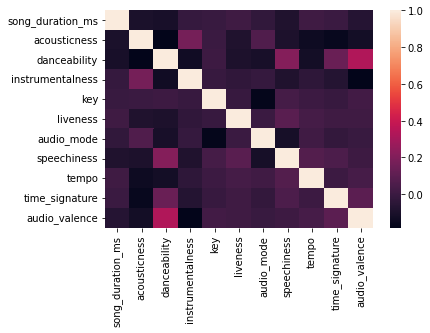

In [ ]:
sns.heatmap(X.corr())



## On visual representation it was found that there was no presence of strong correlation  among variables

## VARIATION INFLATION FACTOR TO CHECK MULTICOLINEARITY AMONG VARIABLES
#### The VIF further bolsters the presence of multicolinearity among the feature variables.

In [ ]:
def calculate_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with features removed
    '''
    const = add_constant(df)
    cols = const.columns
    variables = np.arange(const.shape[1])
    vif_df = pd.Series([variance_inflation_factor(const.values, i) 
               for i in range(const.shape[1])], 
              index=const.columns).to_frame()

    vif_df = vif_df.sort_values(by=0, ascending=False).rename(columns={0: 'VIF'})
    vif_df = vif_df.drop('const')
    vif_df = vif_df[vif_df['VIF'] > thresh]

    print ("Features above VIF threshold:\n")
    print (f"{vif_df[vif_df['VIF'] > thresh]}")
    col_to_drop = list(vif_df.index)

    for i in col_to_drop:
        print ('Dropping: {}'.format(i))
        df = df.drop(columns=i)

    return df

In [ ]:
new_df = calculate_vif_(X, thresh=5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Features above VIF threshold:

Empty DataFrame
Columns: [VIF]
Index: []


#### Since  no df is returned so its signifies that there is no colinearity among the features in dataset

## Model Building and Model Evaluation

In [ ]:
y = df["song_popularity"]
X = df.drop(["song_popularity"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
lin_reg_model = LinearRegression().fit(X_train, y_train)
pred_y = lin_reg_model.predict(scaler.fit_transform(X_test))
print("MSE: {}".format(metrics.mean_squared_error(y_test, pred_y)))

MSE: 451.18599697646283


In [ ]:

print("The MAE is mean_absolute_error:",mean_absolute_error(y_test, pred_y))

MAE: 16.879589259708172


In [ ]:

print(" The RMSE is RMSE mean_squared_error:",math.sqrt(mean_squared_error(y_test, pred_y)))

RMSE: 21.241139257969728


## IMPLEMENTING LASSO REGRESSION 

In [ ]:
def score(y_pred, y_true):
  error = np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean() ** 0.5
  score = 1 - error
  return score

In [ ]:
actual_cost = list(y_test)
actual_cost = np.asarray(actual_cost)

In [ ]:
lasso_reg = Lasso(normalize=True)
lasso_reg.fit(X_train,y_train)
y_pred_lass =lasso_reg.predict(X_test)
print("\n\nLasso SCORE : ", score(y_pred_lass, actual_cost))



Lasso SCORE :  0.6646505796163737


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


## The Lasso Regression attained an accuracy of 66.46% with the given Dataset.